In [1]:
# Load the python libraries
import os, sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# some imports from dipy
from dipy.data import fetch_cenir_multib, read_cenir_multib, gradient_table
from dipy.segment.mask import median_otsu

# Import local modules

# Modify the module path (if required) so that we can import
# modules from this repository
module_path = os.path.join(os.path.abspath(os.path.join('.')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices
from freewater_runner import FreewaterRunner
from os.path import join

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Loading Example data from dipy

Since we cannot find publicly available single shell data, we use multishell data from data and transform it to look like single shell data

In [4]:
# !! RUN THIS ONCE ONLY !!
# # Download eddy-current/motion corrected data (a couple of GB will be downloaded)
# fetch_cenir_multib(with_raw=False)

In [2]:
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_fdata()

In [6]:
data.shape

(104, 104, 72, 202)

In [7]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### Loading Customized data

Using below code to generate niigz/bval/bvec

In [8]:
# dcm2niix -z y -o 3129_niigz 3129

In [3]:
dname = r'3323_niigz'
fdwi = join(dname, "3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.nii.gz")
fbval = join(dname, '3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.bval')
fbvec = join(dname, '3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.bvec')
print(fdwi, fbval, fbvec)

3323_niigz\3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.nii.gz 3323_niigz\3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.bval 3323_niigz\3323_DTI_DTI_pulse_gated_AC_PC_line_20120719121427_2.bvec


In [4]:
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)

In [5]:
print(data.shape)

(116, 116, 72, 65)


In [12]:
print(img.header.get_zooms()[:3])

(1.9827586, 1.9827586, 2.0)


We can quickly visualize the results using matplotlib_. For example, let’s show here the middle axial slices of volume 0 and volume 10.

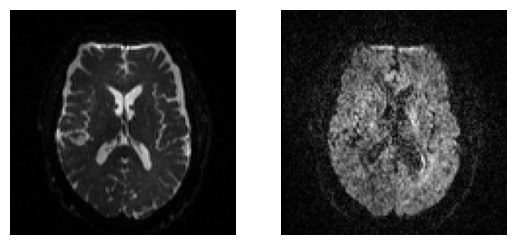

In [13]:
import matplotlib.pyplot as plt

axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

In [14]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [15]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [16]:
print(gtab.info)

B-values shape (65,)
         min 0.000000
         max 1000.000000
B-vectors shape (65, 3)
          min -0.975583
          max 0.999063

None


In [17]:
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000.]


In [18]:
print(gtab.bvecs[:10, :])

[[ 0.         0.         0.       ]
 [ 0.999063   0.0348127  0.0257074]
 [-0.0224362  0.982364  -0.185629 ]
 [-0.0129732  0.496131  -0.868151 ]
 [ 0.615198  -0.784809  -0.0748745]
 [-0.194143  -0.683305  -0.703849 ]
 [-0.873096  -0.356227  -0.332874 ]
 [ 0.81588    0.0418423 -0.576705 ]
 [ 0.221513   0.868365  -0.443706 ]
 [ 0.944502   0.10859   -0.310038 ]]


In [19]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### Process Single shell data

In [20]:
# we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(ss_data, [0], 4, 2, False, dilate=1)

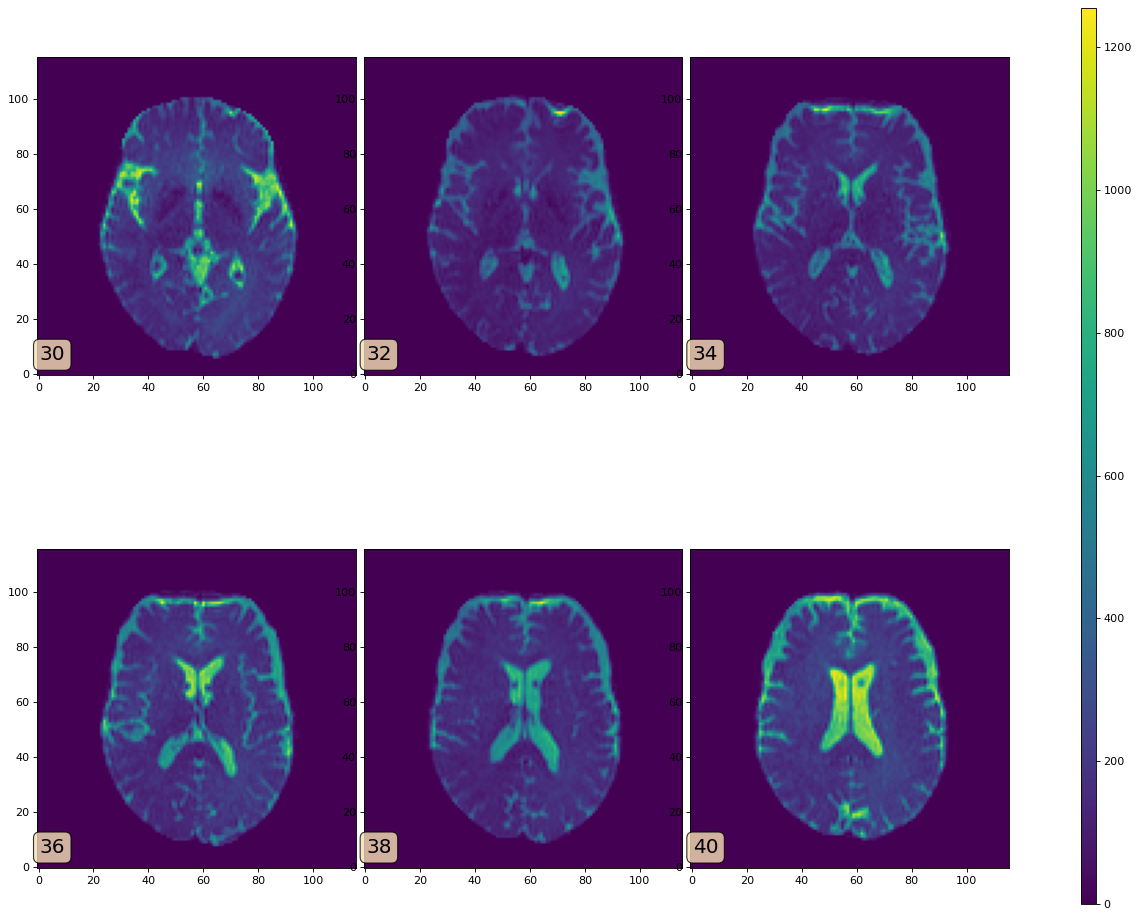

In [21]:
# plot the b0 image for a few z-axis slices
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)
# plt.savefig("b0_image_z-axis_slices.png")

# Work with smaller data and get the freewater maps, FA, corrected-FA etc

In [22]:
fw_runner = FreewaterRunner(maskdata, ss_gtab, 
                                   xslice=slice(10, 90), 
                                   yslice=slice(10, 90), 
                                   zslice=slice(30, 41))
fw_runner.LOG = False # turn off logging for this example
fw_runner.run_model(num_iter=100, dt=0.001)

Stissue = 0.0001 : Swater = 1278.0
Single shell bvalue = 1000.0
Attenuation_min = 0.007, Attenuation_max = 0.990
Ahat.shape = (80, 80, 11, 65)
Awater_k = 0.05
f_init.shape = (80, 80, 11, 1)


#### Check for model convergence

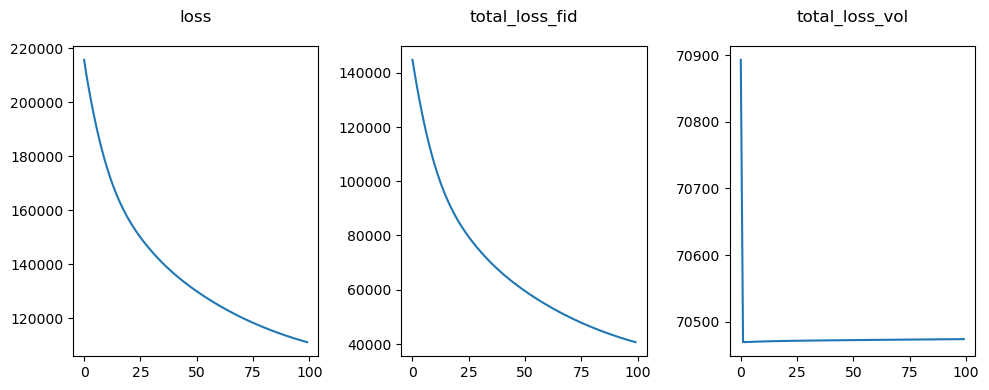

In [23]:
fw_runner.plot_loss()
# plt.savefig("loss.png")

#### Free Water map

<Figure size 640x480 with 0 Axes>

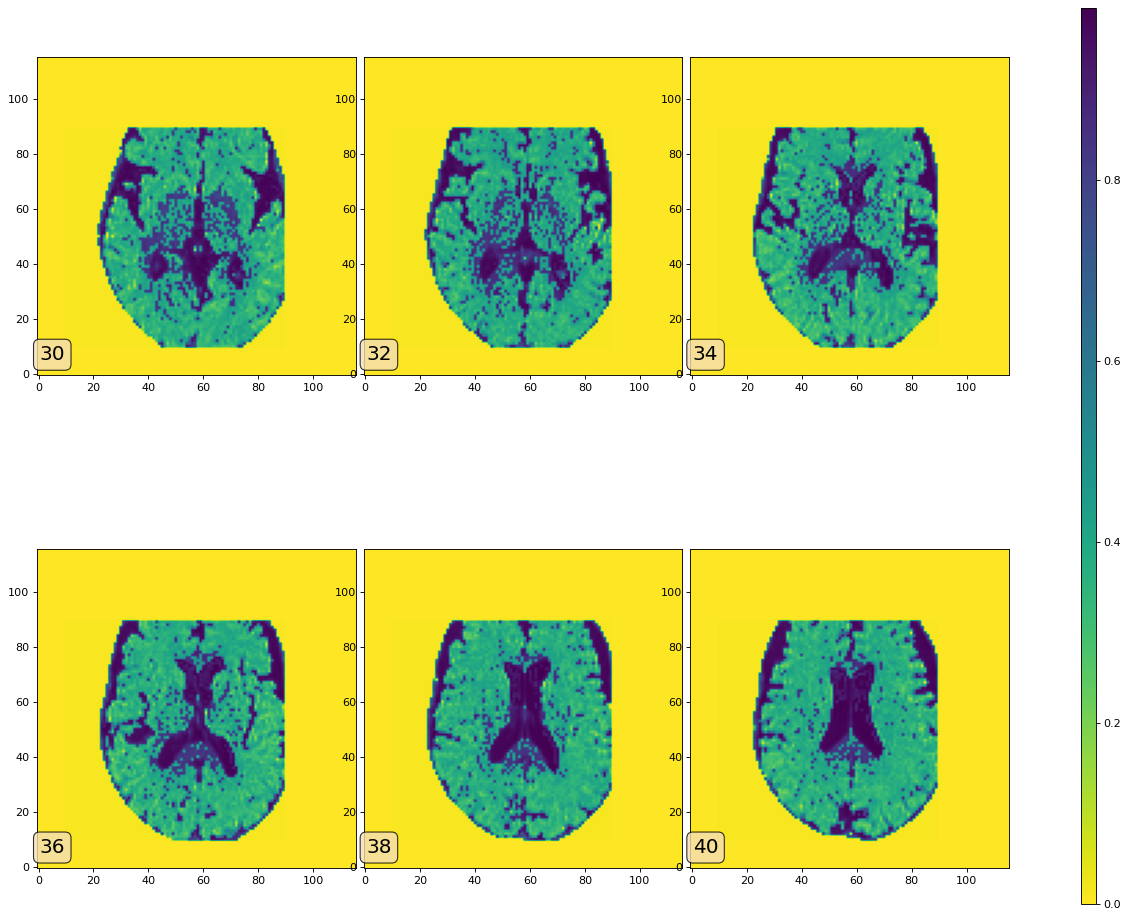

In [24]:
# Free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(fw_runner.get_fw_map(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)
# plt.savefig("free_water_map.png")

#### Mean Diffusivity (free water corrected)

<Figure size 640x480 with 0 Axes>

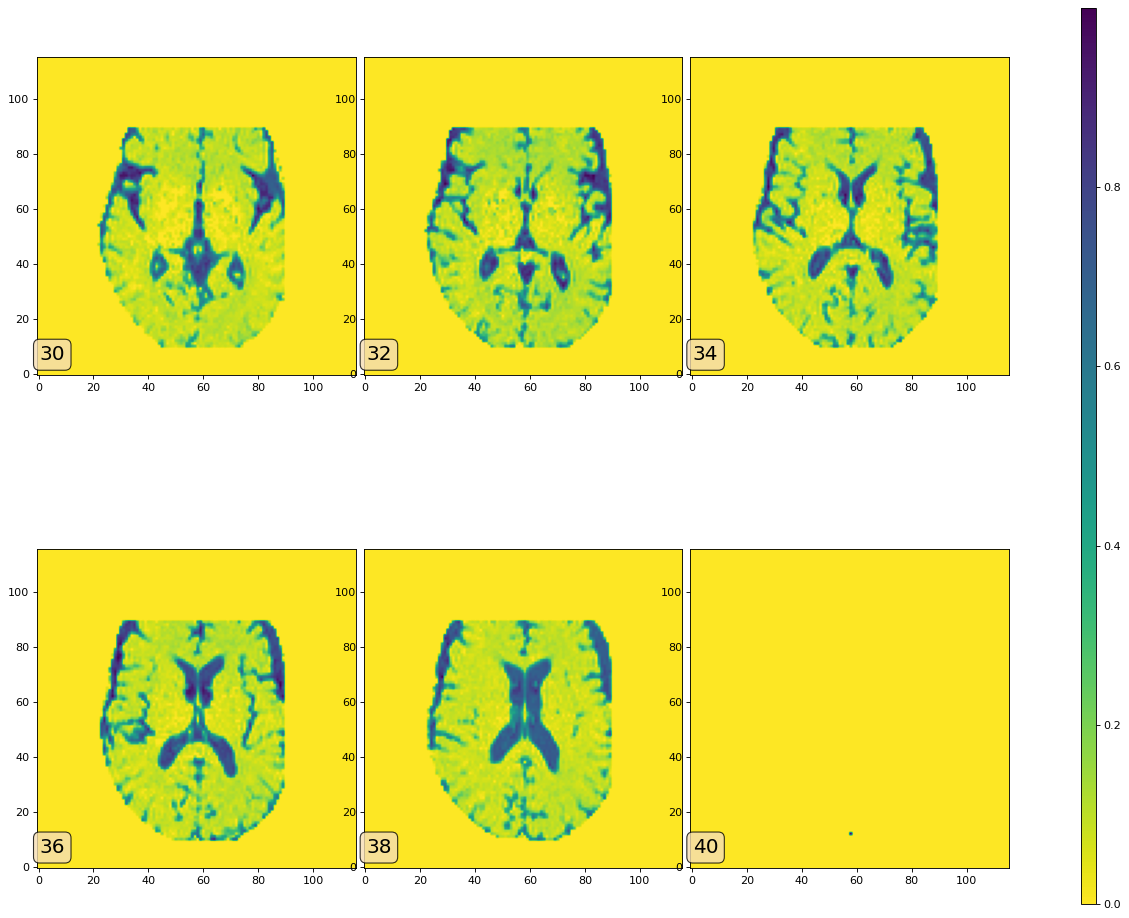

In [25]:
plt.set_cmap("viridis_r")
plot_3d_z_indices(fw_runner.get_fw_md(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)
# plt.savefig("free_water_corrected.png")

#### Fractional Anisotropy (free water corrected)

<Figure size 640x480 with 0 Axes>

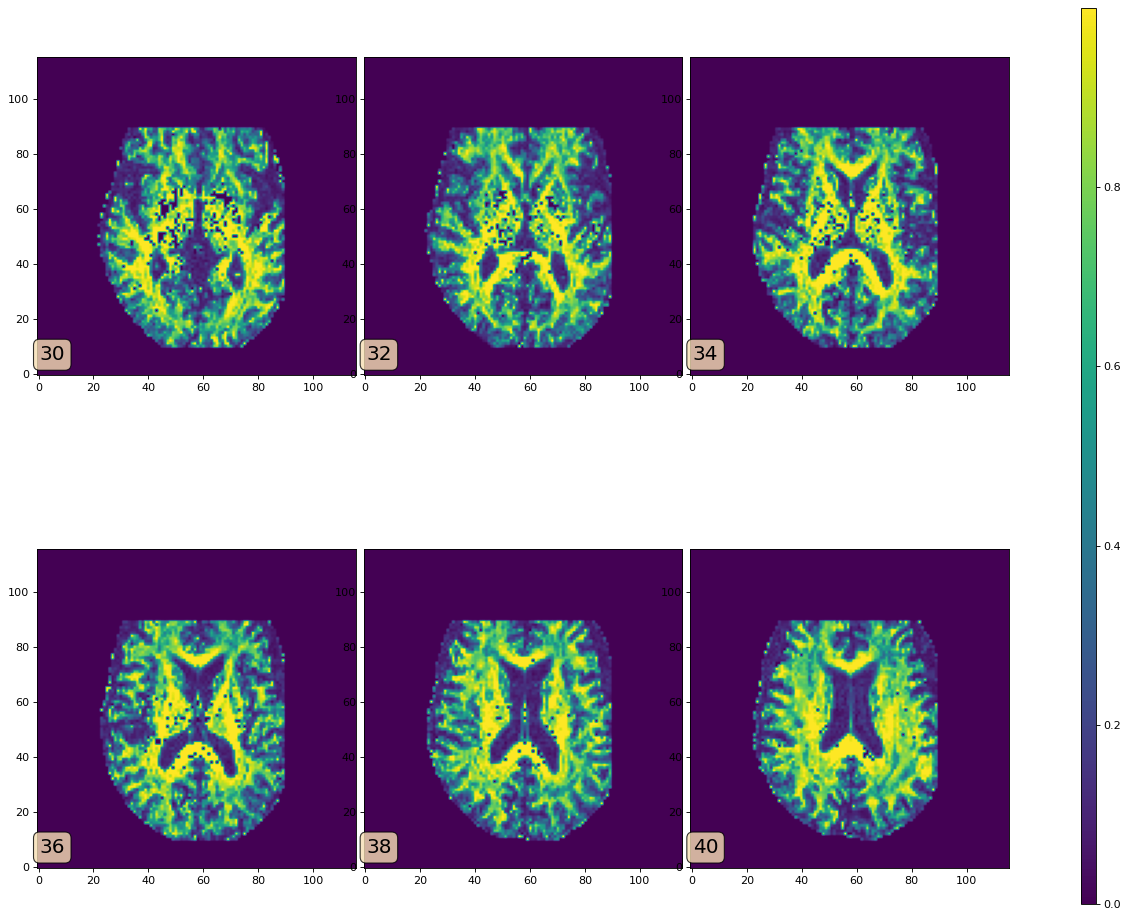

In [26]:
### Freewater corrected Fractional Anisotropy
plt.set_cmap("viridis")
plot_3d_z_indices(fw_runner.get_fw_fa(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)
# plt.savefig("free_water_corrected_fa.png")